In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [21]:
#1データの読み込み　※3つ目は性別のみの仮予想データのため不要
train_data=pd.read_csv("/kaggle/input/titanic/train.csv")
test_data=pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission_data=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

print("正常終了")

正常終了


In [22]:
#2欠損値の確認

# 欠損値の数
missing_train_count = train_data.isnull().sum()
missing_test_count = test_data.isnull().sum()
# len(train_data) は全行数。それに100をかけて％にします
missing_train_percent = (missing_train_count / len(train_data)) * 100
missing_test_percent = (missing_test_count / len(test_data)) * 100
# 数と割合をセットにして見やすく表示
missing_train_table = pd.concat([missing_train_count, missing_train_percent], axis=1)
missing_train_table.columns = ['欠損数', '欠損割合(%)']
missing_test_table = pd.concat([missing_test_count, missing_test_percent], axis=1)
missing_test_table.columns = ['欠損数', '欠損割合(%)']

print("--- 訓練データの欠損 ---")
print(missing_train_table)
print("\n--- テストデータの欠損 ---")
print(missing_test_table)

--- 訓練データの欠損 ---
             欠損数    欠損割合(%)
PassengerId    0   0.000000
Survived       0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age          177  19.865320
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           0   0.000000
Cabin        687  77.104377
Embarked       2   0.224467

--- テストデータの欠損 ---
             欠損数    欠損割合(%)
PassengerId    0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age           86  20.574163
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           1   0.239234
Cabin        327  78.229665
Embarked       0   0.000000


In [23]:
#3表示
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

print("[train]\n",train_data.head(10),"\n",train_data.tail(10),"\n\n[test]")
print(test_data.head(),"\n\n[gender]")
print(gender_submission_data.head())

[train]
    PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   
5            6         0       3    male   NaN      0      0   
6            7         0       1    male  54.0      0      0   
7            8         0       3    male   2.0      3      1   
8            9         1       3  female  27.0      0      2   
9           10         1       2  female  14.0      1      0   

             Ticket     Fare Cabin Embarked  
0         A/5 21171   7.2500   NaN        S  
1          PC 17599  71.2833   C85        C  
2  STON/O2. 3101282   7.9250   NaN        S  
3            113803  53.1000  C123        S  
4            373450   8.0500   NaN        S  
5         

In [24]:
#4欠損補完（年齢、客室、運賃）
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
test_data['Has_Cabin'] = test_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)

test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

display(train_data.head())

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,male,35.0,0,0,373450,8.0500,S,0


Has_Cabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64


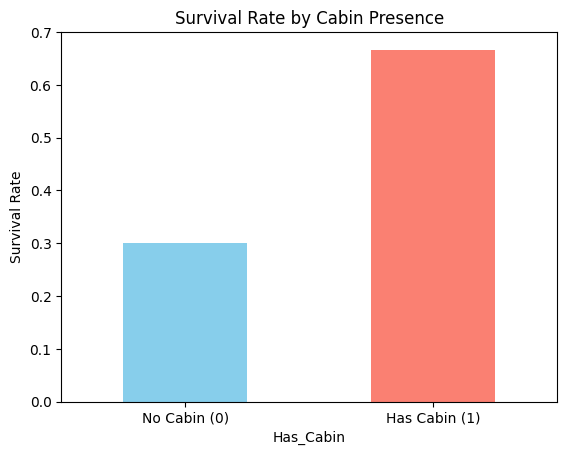

In [25]:
#4_1コラム客室の有意差
cabin_survival = train_data.groupby('Has_Cabin')['Survived'].mean()
print(cabin_survival)
import matplotlib.pyplot as plt
cabin_survival.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['No Cabin (0)', 'Has Cabin (1)'], rotation=0)
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Cabin Presence')
plt.show()

#想定　客室の欠損値の割合から、ゲストルームのみ客室の記載をし、一般客は記載しない（欠損値）と仮定しました。
#     その場合であれば、ゲストのほうが脱出時に優先されるケースが想定されるため、有意差の確認を実施しました。

In [26]:
#5質的データから量的データへの置換（性別、乗船港）
train_data['Sex'] = train_data['Sex'].replace({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].replace({'male': 0, 'female': 1})

train_data['Embarked'] = train_data['Embarked'].fillna('S')
train_data['Embarked'] = train_data['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
test_data['Embarked'] = test_data['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})

/tmp/ipykernel_55/1055242658.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Sex'] = train_data['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_55/1055242658.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data['Sex'] = test_data['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_55/1055242658.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

In [45]:
#6ランダムフォレスト精度確認
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

features = ["Pclass", "Sex", "Age", "Fare", "Has_Cabin"]
X = train_data[features]
y = train_data["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

val_predictions = model.predict(X_val)
score = accuracy_score(y_val, val_predictions)

print(f"精度確認: {score:.2%}")

精度確認: 81.56%


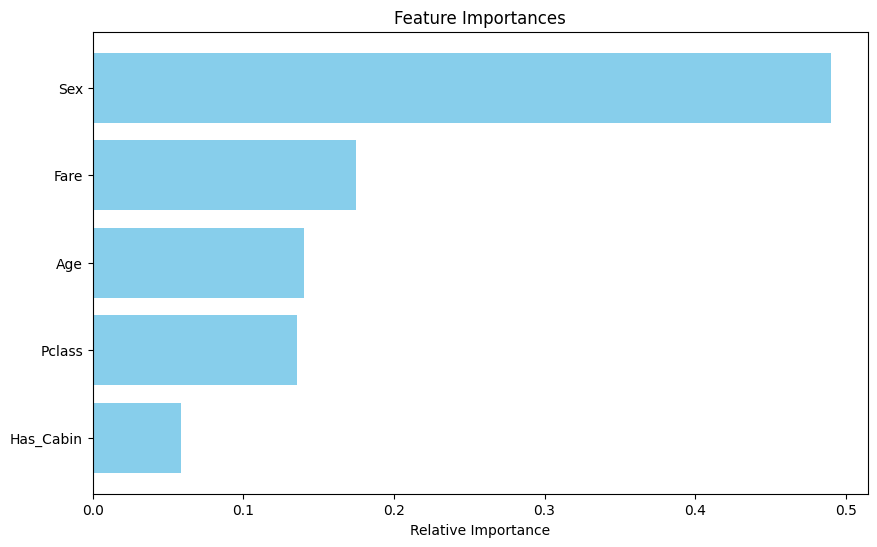

In [46]:
#7寄与度の確認
import numpy as np

# 重要度を取得
importances = model.feature_importances_
indices = np.argsort(importances)

# グラフ化
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#寄与度の低いSibSp、Parchを♯6から削除 

In [59]:
#提出モデル
X_full = train_data[features]
y_full = train_data["Survived"]
final_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
final_model.fit(X_full, y_full)

X_test = test_data[features]
predictions = final_model.predict(X_test)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [60]:
#csv作成
output = pd.DataFrame({'PassengerId': test_data['PassengerId'],'Survived': predictions})
output.to_csv('submission_titanic.csv', index=False)